In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
df = pd.read_csv('Cleansed Set B Corporate Rating.csv')

In [14]:
#brief look into the data
df.head()

,Bond Rating,Cash,Earnings Before Interest,Gross Profit (Loss),Retained Earnings,EBTI Margin (Revenue),Dividends per Share - Pay Date - Calendar,Total Stockholders Equity,Total Market Value (Fiscal Years),Total Revenue,Financing Activities - Net Cash Flow,Net Cash Flow,Debt to Equity Ratio,Return on Asset,Interest Coverage,Current Ratio,Return on Equity,Quick Ratio,Risk Rating
0,B+,994.000,6585.000,13139.000,-13121.000,0.154396,0.2000,2021.000,37405.5843,42650.000,-315.000,2765.000,8.013855,0.150442,0.138952,0.078187,6.048491,0.038898,High Risk
1,A-,7.604,1228.600,1228.600,1857.924,0.351870,2.2975,4519.102,7553.1050,3491.632,-178.881,920.746,0.670756,0.085835,0.163560,0.038974,0.227401,0.001124,Low Risk
2,A+,4063.000,4475.000,12088.000,17821.000,0.221020,0.8800,21639.000,67891.7357,20247.000,-2742.000,933.000,0.157493,0.108419,0.033520,0.413236,0.551689,0.250370,Low Risk
3,BB+,466.829,134.767,308.828,1759.236,0.204120,0.6838,2045.311,2667.9542,660.235,-45.802,87.781,0.000000,0.060959,0.020762,3.724350,0.149625,2.821401,High Risk
4,A,1420.400,4848.700,15091.500,9940.400,0.083594,0.9000,14551.800,31072.7340,58003.200,-1235.000,2137.800,0.539590,0.090796,0.067915,0.045822,1.014459,0.045822,Low Risk


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

In [16]:
custom_mapping = {
    'In Default': 5,
    'Highest Risk': 4,
    'High Risk': 3,
    'Medium Risk': 2,
    'Low Risk': 1,
    'Lowest Risk': 0
}

X = df.drop(columns=['Risk Rating', 'Bond Rating', 'Financing Activities - Net Cash Flow'])
y = df['Risk Rating'].map(custom_mapping)

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

In [17]:
# Model 1: Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

# Model 2: Logistic Regression
logreg_model = LogisticRegression(solver='liblinear', random_state=42)
logreg_model.fit(X_train, y_train)
logreg_pred = logreg_model.predict(X_test)

# Model 3: Decision Tree
dectree_model = DecisionTreeClassifier(random_state=42)
dectree_model.fit(X_train, y_train)
dectree_pred = dectree_model.predict(X_test)

# Model 4: XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

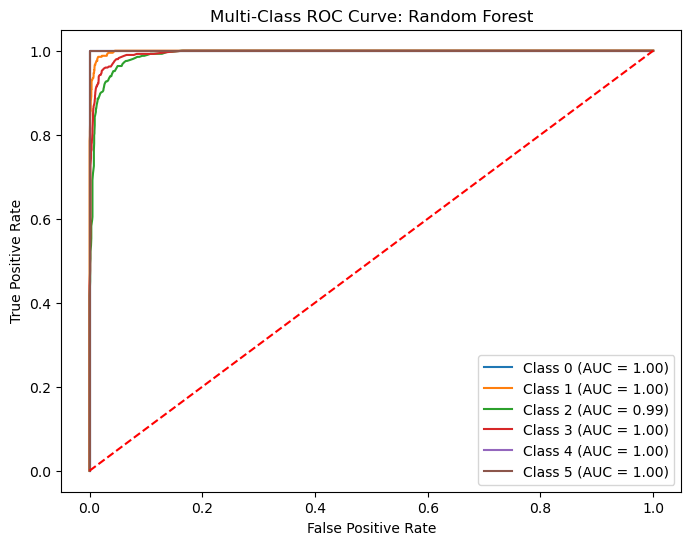

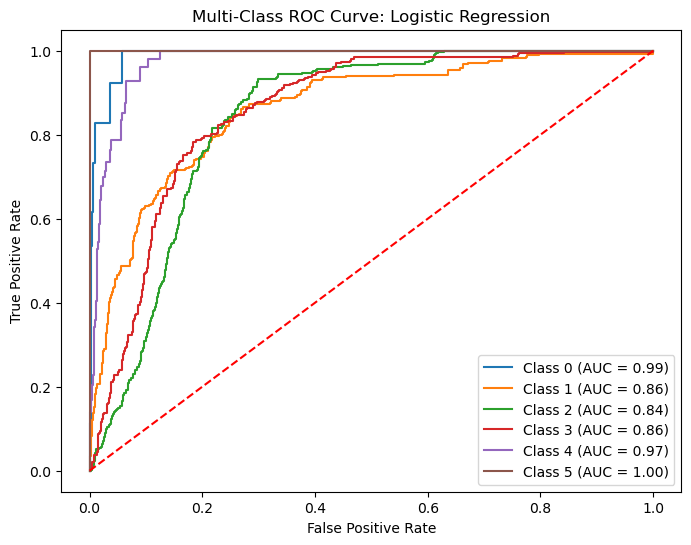

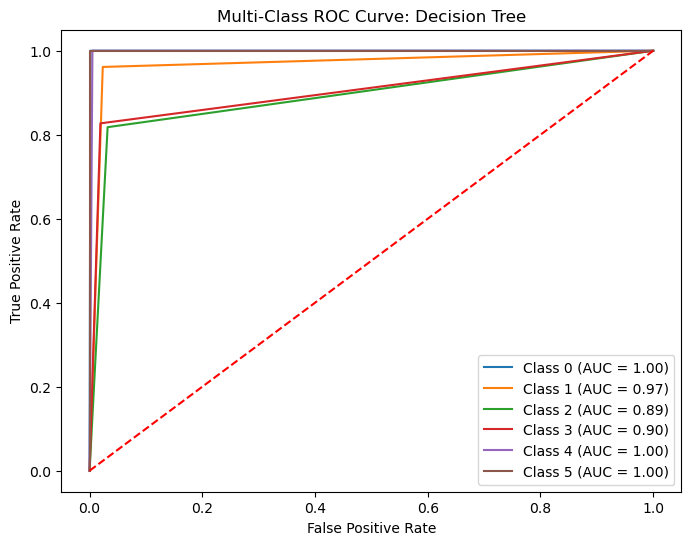

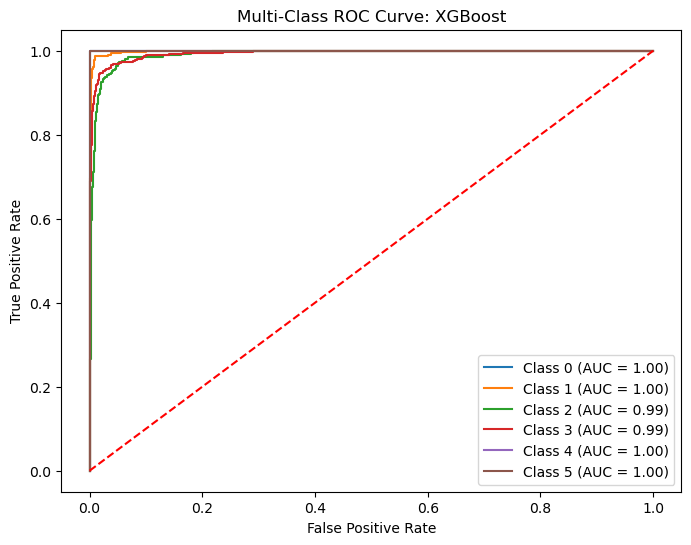

In [18]:
classes = np.unique(y_test)
y_test_binarized = label_binarize(y_test, classes=classes)
n_classes = len(classes)

pred1 = rf.predict_proba(X_test)
pred2 = logreg_model.predict_proba(X_test)
pred3 = dectree_model.predict_proba(X_test)
pred4 = dectree_model.predict_proba(X_test)

models = [
    ("Random Forest", rf.predict_proba(X_test)),
    ("Logistic Regression", logreg_model.predict_proba(X_test)),
    ("Decision Tree", dectree_model.predict_proba(X_test)),
    ("XGBoost", xgb_model.predict_proba(X_test)),
]

for model_name, pred in models:
    plt.figure(figsize=(8, 6))
    plt.title(f'Multi-Class ROC Curve: {model_name}')
    
    for i, class_label in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'r--')  # Random chance line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

From the above auc-roc graphs, we can see that XGBoost model performed the best, followed by Random Forest model. We will be using XGBoost Model as our main model and try to fine-tune the model to make it better.

Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       370
           1       0.95      0.99      0.97       414
           2       0.91      0.92      0.91       412
           3       0.96      0.88      0.92       399
           4       0.97      1.00      0.98       398
           5       1.00      1.00      1.00       389

    accuracy                           0.96      2382
   macro avg       0.96      0.96      0.96      2382
weighted avg       0.96      0.96      0.96      2382

Accuracy:  0.9626364399664148


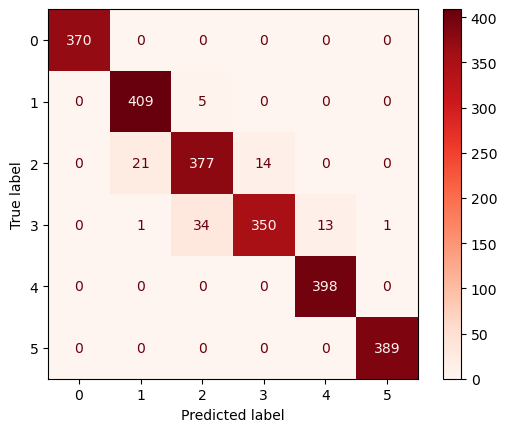

In [19]:
ConfusionMatrixDisplay.from_predictions(y_test, xgb_pred, cmap=plt.cm.Reds, normalize=None, display_labels=[0,1,2,3,4,5])
print(f"Classification Report: \n{classification_report(y_test, xgb_pred)}")
print(f"Accuracy:  {accuracy_score(y_test, xgb_pred)}")

The current accuracy of the xgboost model is at 0.834. However, when it comes to precision and recall, some of the class has much lower percentage as compared to others. Class 0 and Class 4 has low data sample which might be a root cause.

In [20]:
class_count = y_train.value_counts()

minority_class = class_count.idxmin()

smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)



Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       370
           1       0.95      0.98      0.96       414
           2       0.90      0.92      0.91       412
           3       0.96      0.87      0.92       399
           4       0.97      1.00      0.98       398
           5       1.00      1.00      1.00       389

    accuracy                           0.96      2382
   macro avg       0.96      0.96      0.96      2382
weighted avg       0.96      0.96      0.96      2382

Accuracy: 0.9609571788413098


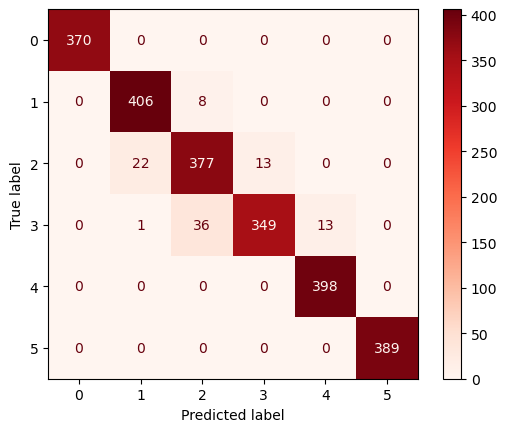

In [21]:
updated_xgb_model = xgb.XGBClassifier(random_state = 42)
updated_xgb_model.fit(X_resampled, y_resampled)

updated_xgb_pred = updated_xgb_model.predict(X_test)

print(f"Classification Report: \n{classification_report(y_test, updated_xgb_pred)}")
print(f"Accuracy: {accuracy_score(y_test, updated_xgb_pred)}")
ConfusionMatrixDisplay.from_predictions(y_test, updated_xgb_pred, cmap=plt.cm.Reds, normalize=None, display_labels=[0,1,2,3,4,5])

In [22]:
import pickle as pkl
ratings_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['Risk Rating'])], axis=1)

with open('updated_xgb_model.pkl', 'wb') as file:
    pkl.dump(updated_xgb_model, file)

with open('data.pkl','wb') as file:
    pkl.dump(ratings_resampled, file)